# Plot the Aggregated Fields using Bootstrap Significance

This sheet is for akns

In [1]:
import cmocean.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
thefile = '/scratch/allen/MIDOSS/aggregate/thirtysecond_200_akns.nc'
oil = xr.open_dataset(thefile)
whichspills = "AKNS Spills"

In [3]:
mesh = xr.open_dataset('~/MEOPAR/grid/mesh_mask201702.nc')
divarea = 1/(mesh.e1t[0, 1:-1, 1:-1] * mesh.e2t[0, 1:-1, 1:-1])
alength = 1/np.maximum(mesh.e1t[0, 1:-1:, 1:-1], mesh.e2t[0, 1:-1, 1:-1])
tmask = 1- mesh.tmask[0, 0]
mesh.close()

In [4]:
imin = 110
jmin, jmax = 40, 380
imax = imin + (jmax - jmin)*2/500*440


In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [6]:
minColor = 0.1
maxColor = 0.85
thermal_r_t = truncate_colormap(cm.thermal_r, minColor, maxColor)

## Beaching

### Beaching Presence: Set-up and Preparation

In [7]:
ma_beaching_pres = np.ma.masked_array(oil.beachpresence, oil.beachpresence == 0)

### Beaching Presence: Plot

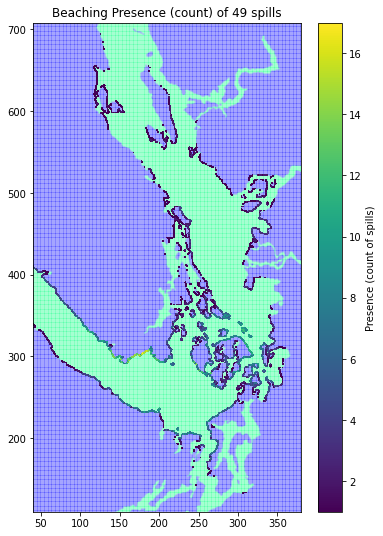

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)


C = ax.pcolormesh(
     ma_beaching_pres,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=ax);    
cb.set_label('Presence (count of spills)')
ax.set_title(f'Beaching Presence (count) of {oil.nofiles.values} spills');   

### Beaching Time: Set-up and Preparation

In [9]:
# Good if good to half a day or 15% of beaching time
absol = 0.5
perol = 0.15
eps = 1e-7
mcsize = 49

bt_absol = absol
bt_perol = perol

In [10]:
ma_beaching_time = np.ma.masked_array(oil.beaching_time[0]/(oil.beachpresence + eps), oil.beachpresence == 0)

den = np.minimum(np.array(oil.beachpresence) + eps, mcsize)
beached_ste = np.std(oil.beaching_time, axis=0, ddof=1) / np.sqrt(den)
beached = np.ma.masked_array(oil.beaching_time[0]/(oil.beachpresence + eps), (oil.beachpresence <= 1) | (
    (beached_ste/(oil.beachpresence+eps) > absol) | (beached_ste > perol*oil.beaching_time[0]))) 

ma_beached_ste = np.ma.masked_array(beached_ste/(oil.beachpresence + eps), oil.beachpresence <= 1)

### Beaching Time: Plot

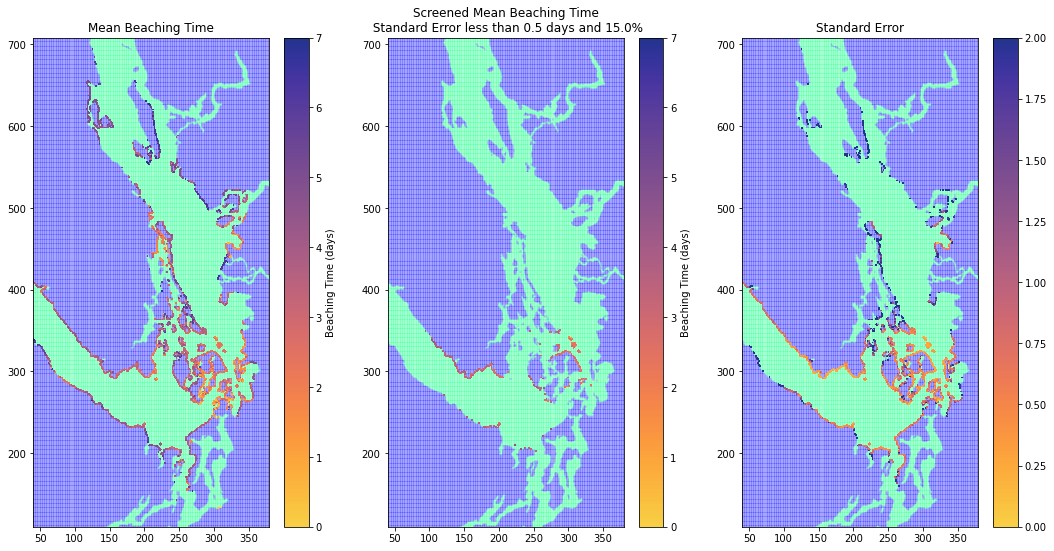

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)

C = axs[0].pcolormesh(
     ma_beaching_time,
    zorder=2, vmin=0, vmax=7, cmap=thermal_r_t
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Beaching Time (days)')
axs[0].set_title('Mean Beaching Time')
    
C = axs[1].pcolormesh(
     beached,
    zorder=2, vmin=0, vmax=7, cmap=thermal_r_t
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beaching Time (days)')
axs[1].set_title(f'Screened Mean Beaching Time\n Standard Error less than {bt_absol} days and {bt_perol*100}%')

C = axs[2].pcolormesh(
     ma_beached_ste,
    zorder=2, vmin=0, vmax=2, cmap=thermal_r_t
)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('Standard Error');

### Beaching Volume: Set-up and Preparation

In [12]:
# Good if good to 100% of beaching volume
perol = 1
absol = np.log(perol+1)

bv_perol = perol

In [13]:
ma_beach_oil = np.ma.masked_array(oil.beaching_oil[0]/(oil.beachpresence + eps), oil.beachpresence == 0)

den = np.minimum(np.array(oil.beachpresence) + eps, mcsize)
beachoil_ste = np.std(oil.beaching_oil/(oil.beachpresence + eps), axis=0, ddof=1) / np.sqrt(den)
beachedoil = np.ma.masked_array(oil.beaching_oil[0]/(oil.beachpresence + eps), (oil.beachpresence <= 1) | (
    (beachoil_ste > absol) )) 

ma_beachoil_ste = np.ma.masked_array(beachoil_ste, oil.beachpresence <= 0)

<xarray.DataArray ()>
array(0.12186701)
Coordinates:
    grid_x   int64 310
    grid_y   int64 315
    grid_z   int16 39
0.6178743124072292
ste <xarray.DataArray ()>
array(0.26976411)
Coordinates:
    grid_x   int64 310
    grid_y   int64 315
    grid_z   int16 39 0.6931471805599453
<xarray.DataArray 'beachpresence' ()>
array(10.)
Coordinates:
    grid_x   int64 310
    grid_y   int64 315
    grid_z   int16 ...
0.2697641145184296
* 0.6178743124072292
31.351858739066277
0.07172827946764489


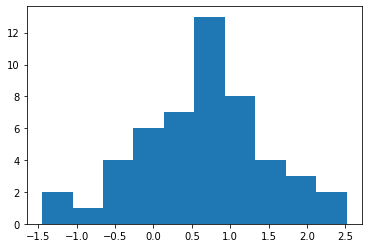

In [14]:
plt.hist(oil.beaching_oil[:, 315, 310]/(oil.beachpresence[315, 310] + eps))
print (np.std(oil.beaching_oil[:, 315, 310]/(oil.beachpresence[315, 310] + eps), axis=0, ddof=1) 
       / np.sqrt(mcsize))
print (ma_beach_oil[315, 310])
print ('ste', beachoil_ste[315, 310], absol)
print (oil.beachpresence[315, 310])
print (ma_beachoil_ste[315, 310])
print ('*', beachedoil[315, 310])
print (np.exp(beachedoil.max()))
print (np.exp(beachedoil.min()))

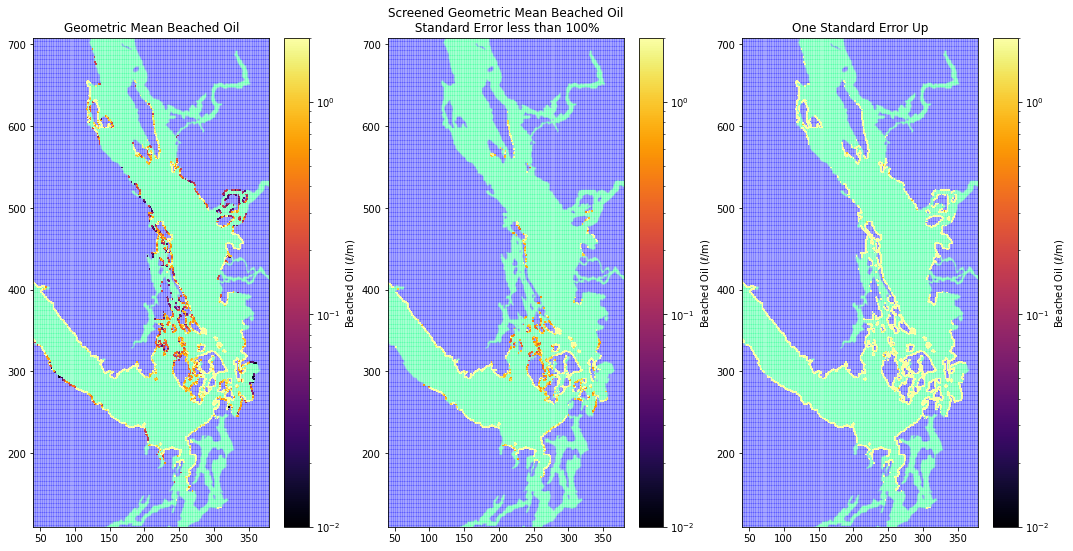

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

vmin, vmax = 0.01, 2

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)

C = axs[0].pcolormesh(
     np.exp(ma_beach_oil) * alength * 1000, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Beached Oil ($\ell$/m)')
axs[0].set_title('Geometric Mean Beached Oil')
    
C = axs[1].pcolormesh(
     np.exp(beachedoil) * alength * 1000,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beached Oil ($\ell$/m)')
axs[1].set_title(f'Screened Geometric Mean Beached Oil\n Standard Error less than {perol*100}%')

C = axs[2].pcolormesh(
     (np.exp(ma_beachoil_ste + ma_beach_oil) - np.exp(ma_beach_oil)) * alength * 10000, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('Beached Oil ($\ell$/m)')
axs[2].set_title('One Standard Error Up');

## Surface Oil

### Surface Oil Presence: Set-up and Prep

In [16]:
ma_oil_pres = np.ma.masked_array(oil.oilpresence, oil.oilpresence == 0)

### Surface Oil Presence: Plot

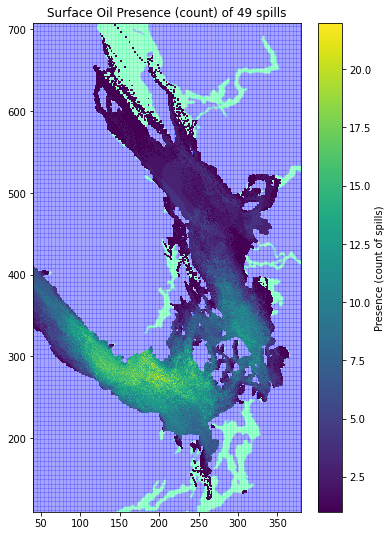

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)

C = ax.pcolormesh(ma_oil_pres, zorder=2)
cb = fig.colorbar(C, ax=ax);    
cb.set_label('Presence (count of spills)')
ax.set_title(f'Surface Oil Presence (count) of {oil.nofiles.values} spills');   

### Oil Arrival Time: Set-up and Preparation

In [18]:
# Good if good to half a day or 15% of arrival time
absol = 0.5
perol = 0.15

at_absol = absol
at_perol = perol

In [19]:
ma_arrival_time = np.ma.masked_array(oil.oiling_time[0]/(oil.oilpresence + eps), oil.oilpresence == 0)

den = np.minimum(np.array(oil.oilpresence) + eps, mcsize)
arrival_ste = np.std(oil.oiling_time, axis=0, ddof=1) / np.sqrt(den)
arrived = np.ma.masked_array(oil.oiling_time[0]/(oil.oilpresence + eps), (oil.oilpresence <= 1) | (
    (arrival_ste/(oil.oilpresence+eps) > absol) | (arrival_ste > perol*oil.oiling_time[0]))) 

ma_arrived_ste = np.ma.masked_array(arrival_ste/(oil.oilpresence + eps), oil.oilpresence <= 1)

### Oil Arrival: Plot

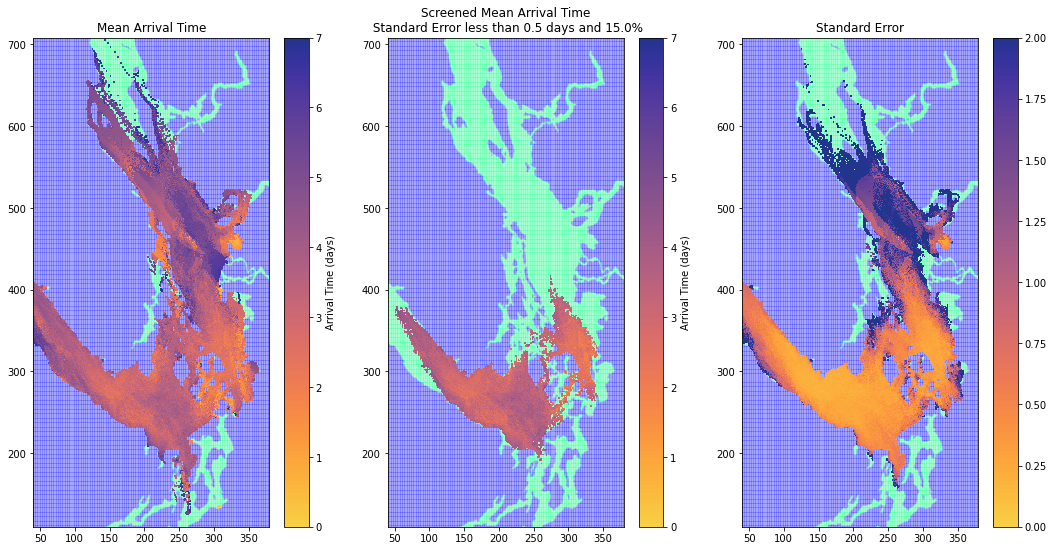

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)

C = axs[0].pcolormesh(ma_arrival_time, zorder=2, vmin=0, vmax=7, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Arrival Time (days)')
axs[0].set_title('Mean Arrival Time')
    
C = axs[1].pcolormesh(arrived, zorder=2, vmin=0, vmax=7,cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Arrival Time (days)')
axs[1].set_title(f'Screened Mean Arrival Time\n Standard Error less than {at_absol} days and {at_perol*100}%')

C = axs[2].pcolormesh(ma_arrived_ste, zorder=2, vmin=0, vmax=2, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('Standard Error');

### Surface Oil Volume: Set-up and Preparation

In [21]:
# Good if good to 100% of beaching volume
perol = 1
absol = np.log(perol+1)

sv_perol = perol

In [22]:
ma_surface_oil = np.ma.masked_array(oil.surface_oil[0]/(oil.oilpresence + eps), oil.oilpresence == 0)

den = np.minimum(np.array(oil.oilpresence) + eps, mcsize)
surfoil_ste = np.std(oil.surface_oil/(oil.oilpresence + eps), axis=0, ddof=1) / np.sqrt(den)
surfoiled = np.ma.masked_array(oil.surface_oil[0]/(oil.oilpresence + eps), (oil.oilpresence <= 1) | (
    (surfoil_ste > absol) )) 

ma_surfoil_ste = np.ma.masked_array(surfoil_ste, oil.oilpresence <= 0)

<xarray.DataArray ()>
array(0.14810556)
Coordinates:
    grid_x   int64 300
    grid_y   int64 400
    grid_z   int16 39
0.4422697916441837
ste <xarray.DataArray ()>
array(0.51836945)
Coordinates:
    grid_x   int64 300
    grid_y   int64 400
    grid_z   int16 39 0.6931471805599453
<xarray.DataArray 'oilpresence' ()>
array(4.)
Coordinates:
    grid_x   int64 300
    grid_y   int64 400
    grid_z   int16 ...
0.5183694532569314
* 0.4422697916441837
61.66107553246726
0.07327989759608144
7.0


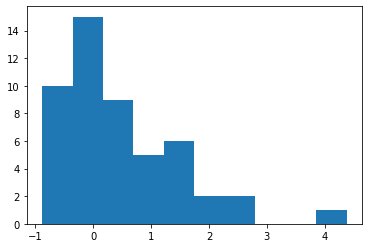

In [23]:
plt.hist(oil.surface_oil[:, 400, 300]/(oil.oilpresence[400, 300] + eps))
print (np.std(oil.surface_oil[:, 400, 300]/(oil.oilpresence[400, 300] + eps), axis=0, ddof=1) 
       / np.sqrt(mcsize))
print (ma_surface_oil[400, 300])
print ('ste', surfoil_ste[400, 300], absol)
print (oil.oilpresence[400, 300])
print (ma_surfoil_ste[400, 300])
print ('*', surfoiled[400, 300])
print (np.exp(surfoiled.max()))
print (np.exp(surfoiled.min()))
print (np.sqrt(49))

### Surface Oil: Plots

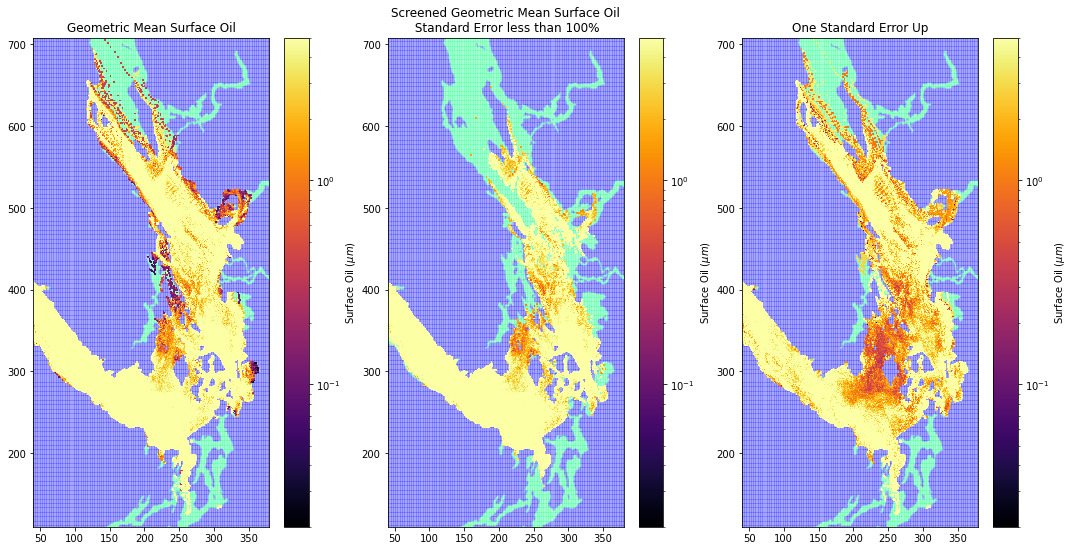

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

vmin, vmax = 0.02, 5

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)

C = axs[0].pcolormesh(
     np.exp(ma_surface_oil) * divarea * 1e6, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Surface Oil ($\mu m$)')
axs[0].set_title('Geometric Mean Surface Oil')
    
C = axs[1].pcolormesh(
     np.exp(surfoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Surface Oil ($\mu m$)')
axs[1].set_title(f'Screened Geometric Mean Surface Oil\n Standard Error less than {perol*100}%')

C = axs[2].pcolormesh(
     (np.exp(ma_surfoil_ste + ma_surface_oil) - np.exp(ma_surface_oil)) * divarea * 1e6, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('Surface Oil ($\mu m$)')
axs[2].set_title('One Standard Error Up');

## Watercolumn Oil

### Watercolumn Presence: Set-up and Preparation

In [25]:
ma_deep_pres = np.ma.masked_array(oil.deeppresence, oil.deeppresence == 0)

### Watercolumn Presence: Plot

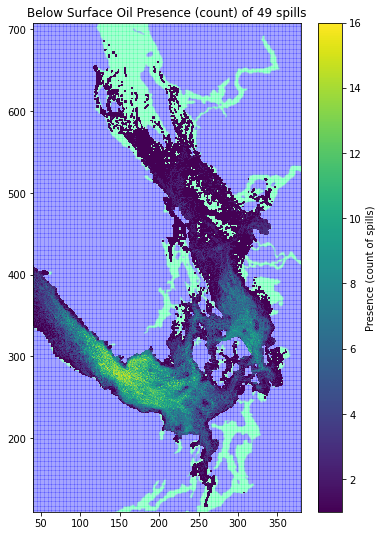

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)

C = ax.pcolormesh(ma_deep_pres, zorder=2)
cb = fig.colorbar(C, ax=ax);    
cb.set_label('Presence (count of spills)')
ax.set_title(f'Below Surface Oil Presence (count) of {oil.nofiles.values} spills');   

### Watercolumn Depth: Set-up and Preparation

In [27]:
# Good if good to 5 m or 25% of depth
absol = 5
perol = 0.25

wd_absol = absol
wd_perol = perol

In [28]:
ma_deep_location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), oil.deeppresence == 0)
den = np.minimum(np.array(oil.deeppresence) + eps, mcsize)
location_ste = np.std(oil.deep_location, axis=0, ddof=1) / np.sqrt(den)
location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), (oil.deeppresence <= 1) | (
    (location_ste/(oil.deeppresence+eps) > absol) | (location_ste > perol*oil.deep_location[0]))) 

ma_location_ste = np.ma.masked_array(location_ste/(oil.deeppresence+eps), location_ste == 0)

4.900243341317295


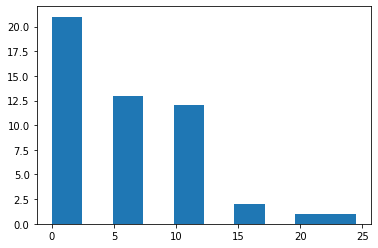

In [29]:
plt.hist(oil.deep_location[:, 400, 300]/oil.deeppresence[400, 300]);
print (ma_deep_location[400, 300])

### Watercolumn Depth: Plot

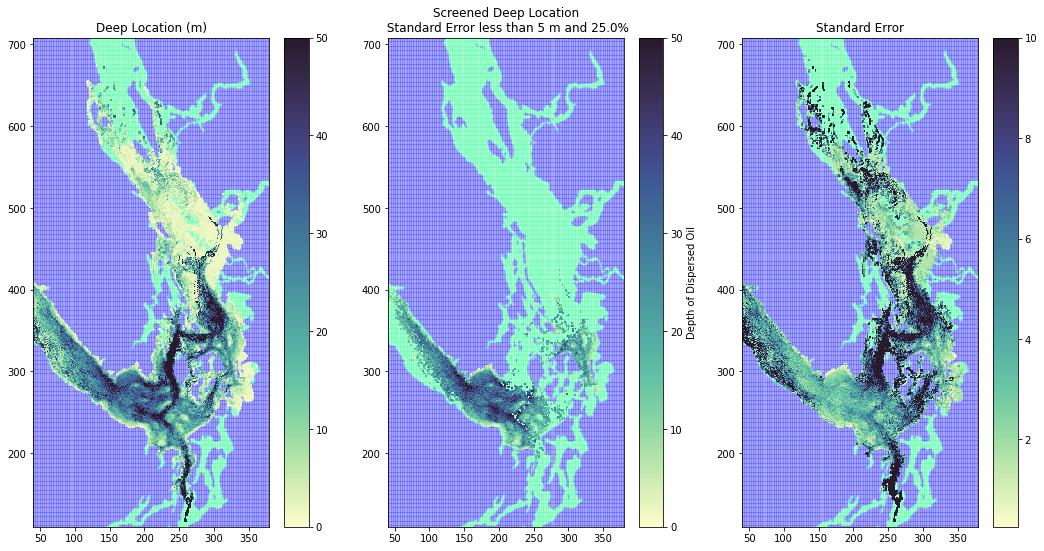

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)


C = axs[0].pcolormesh(
     ma_deep_location,
    zorder=2, vmin=0, vmax=50, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[0]);    
axs[0].set_title('Deep Location (m)');    

C = axs[1].pcolormesh(
     location,
    zorder=2, vmin=0, vmax=50, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Depth of Dispersed Oil')
axs[1].set_title(f'Screened Deep Location\n Standard Error less than {wd_absol} m and {wd_perol*100}%')

C = axs[2].pcolormesh(ma_location_ste, 
    zorder=2, vmax=10, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('Standard Error');

### Watercolumn Volume: Set-up and Preparation

In [31]:
# Good if good to 100% of beaching volume
perol = 1
absol = np.log(perol+1)

dv_perol = perol

In [32]:
ma_deep_oil = np.ma.masked_array(oil.deep_oil[0]/(oil.deeppresence + eps), oil.deeppresence == 0)

den = np.minimum(np.array(oil.deeppresence) + eps, mcsize)
deepoil_ste = np.std(oil.deep_oil/(oil.deeppresence + eps), axis=0, ddof=1) / np.sqrt(den)
deepoiled = np.ma.masked_array(oil.deep_oil[0]/(oil.deeppresence + eps), (oil.deeppresence <= 1) | (
    (deepoil_ste > absol) )) 

ma_deepoil_ste = np.ma.masked_array(deepoil_ste, oil.deeppresence <= 0)

### Watercolumn Volume: Plots

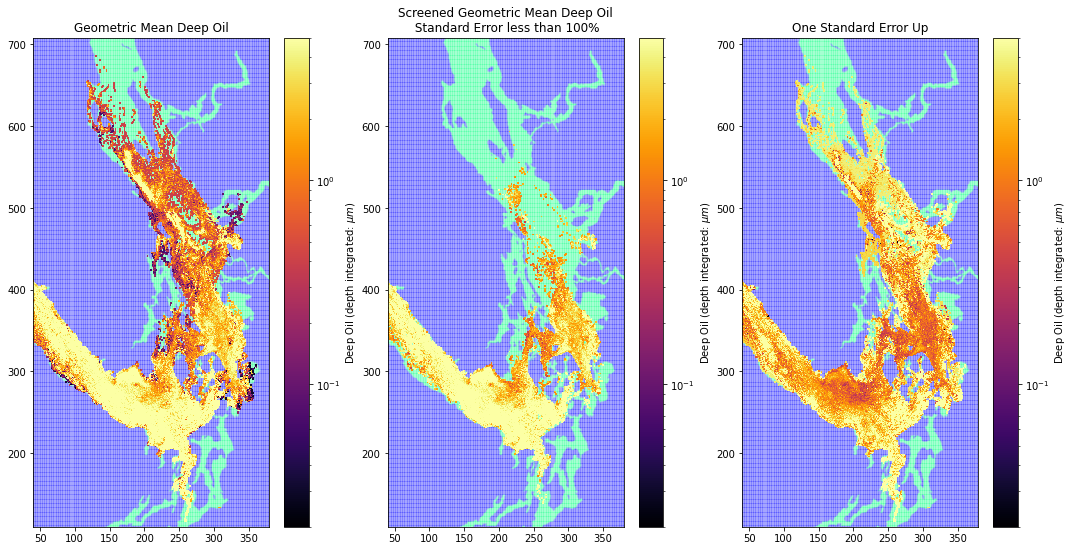

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

vmin, vmax = 0.02, 5

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)

C = axs[0].pcolormesh(
     np.exp(ma_deep_oil) * divarea * 1e6, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Deep Oil (depth integrated: $\mu m$)')
axs[0].set_title('Geometric Mean Deep Oil')
    
C = axs[1].pcolormesh(
     np.exp(deepoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Deep Oil (depth integrated: $\mu m$)')
axs[1].set_title(f'Screened Geometric Mean Deep Oil\n Standard Error less than {perol*100}%')

C = axs[2].pcolormesh(
     (np.exp(ma_deepoil_ste + ma_deep_oil) - np.exp(ma_deep_oil)) * divarea * 1e6, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('Deep Oil (depth integrated: $\mu m$)')
axs[2].set_title('One Standard Error Up');

## Screened Plots

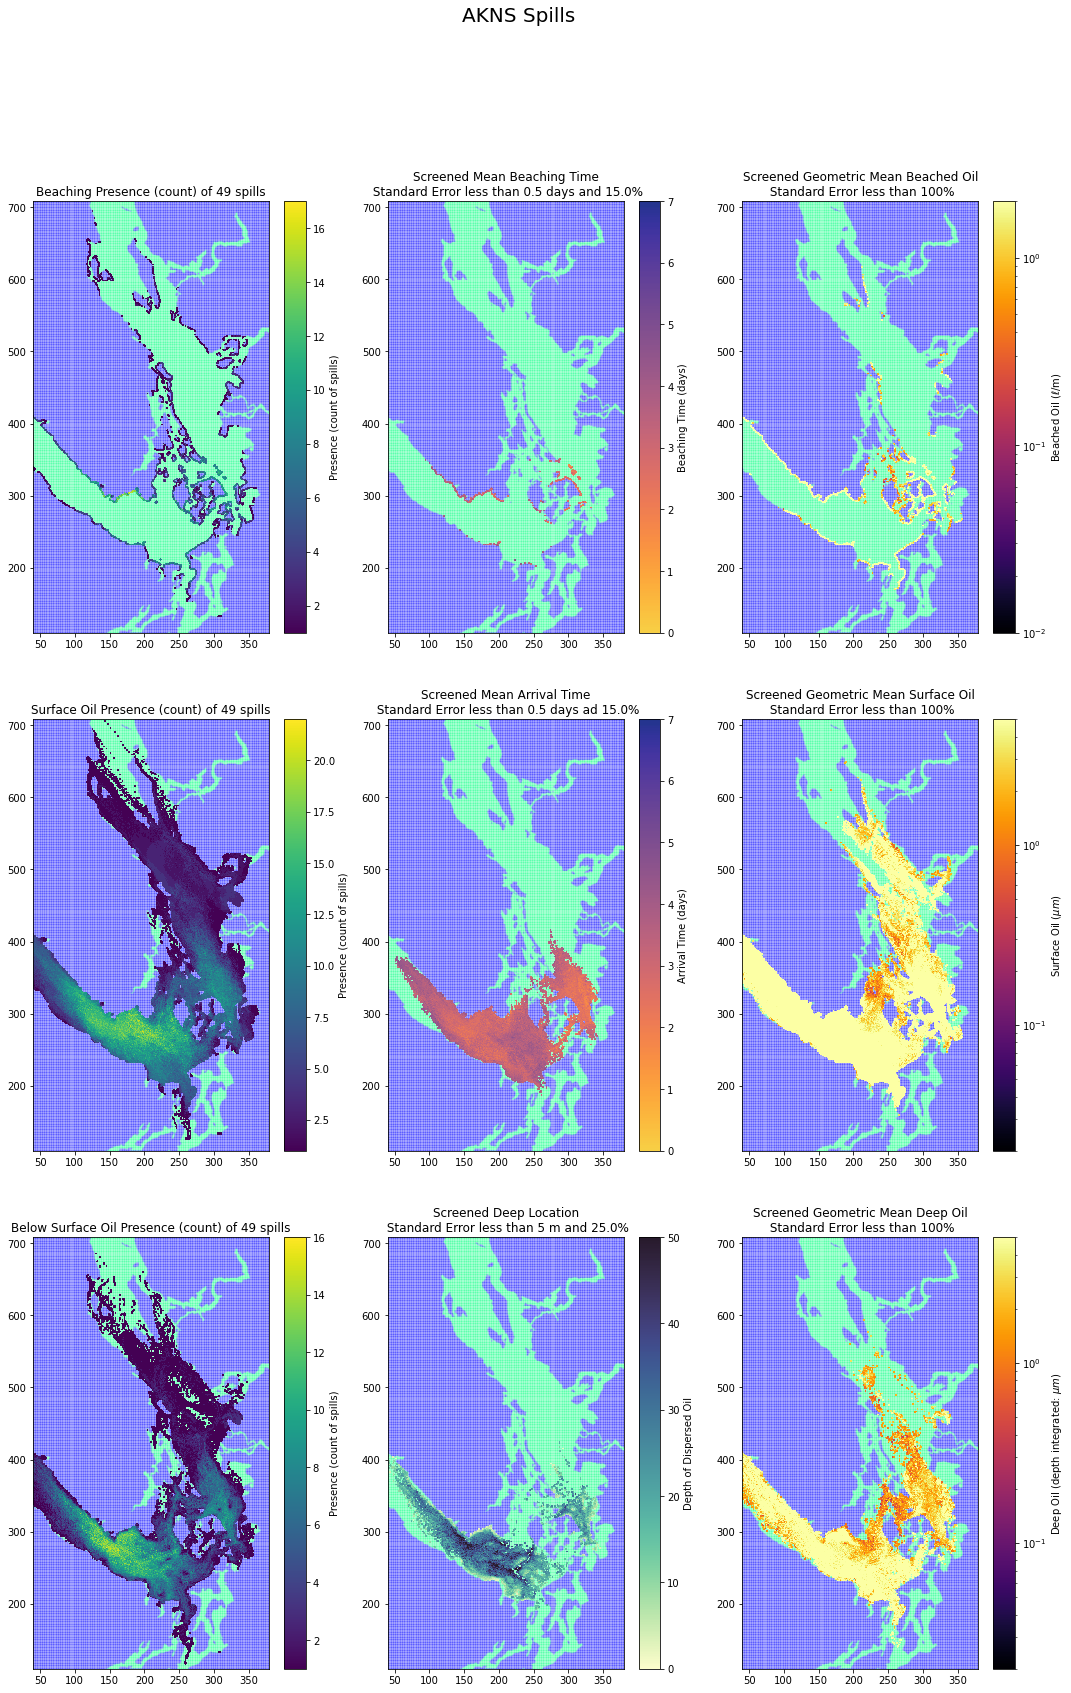

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(18, 9*3))

fig.suptitle(f'{whichspills}', fontsize=20)

for i in range(3):
    for ax in axs[i]:
        ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
        ax.set_ylim(imin, imax)
        ax.set_xlim(jmin, jmax)
        
C = axs[0, 0].pcolormesh(ma_beaching_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[0, 0]);    
cb.set_label('Presence (count of spills)')
axs[0, 0].set_title(f'Beaching Presence (count) of {oil.nofiles.values} spills');   

C = axs[0, 1].pcolormesh(beached, zorder=2, vmin=0, vmax=7, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[0, 1]);
cb.set_label('Beaching Time (days)')
axs[0, 1].set_title(f'Screened Mean Beaching Time\n Standard Error less than {bt_absol} days and {bt_perol*100}%');

C = axs[0, 2].pcolormesh(np.exp(beachedoil) * alength * 1000, zorder=2, norm=colors.LogNorm(vmin=0.01, vmax=2), cmap='inferno')
cb = fig.colorbar(C, ax=axs[0, 2]);
cb.set_label('Beached Oil ($\ell$/m)')
axs[0, 2].set_title(f'Screened Geometric Mean Beached Oil\n Standard Error less than {bv_perol*100}%');

C = axs[1, 0].pcolormesh(ma_oil_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[1, 0]);    
cb.set_label('Presence (count of spills)')
axs[1, 0].set_title(f'Surface Oil Presence (count) of {oil.nofiles.values} spills');  

C = axs[1, 1].pcolormesh(arrived, zorder=2, vmin=0, vmax=7, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[1, 1]);
cb.set_label('Arrival Time (days)')
axs[1, 1].set_title(f'Screened Mean Arrival Time\n Standard Error less than {at_absol} days ad {at_perol*100}%');

C = axs[1, 2].pcolormesh(
     np.exp(surfoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno')
cb = fig.colorbar(C, ax=axs[1, 2]);
cb.set_label('Surface Oil ($\mu m$)')
axs[1, 2].set_title(f'Screened Geometric Mean Surface Oil\n Standard Error less than {sv_perol*100}%');


C = axs[2, 0].pcolormesh(ma_deep_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[2, 0]);    
cb.set_label('Presence (count of spills)')
axs[2, 0].set_title(f'Below Surface Oil Presence (count) of {oil.nofiles.values} spills');   

C = axs[2, 1].pcolormesh(
     location,
    zorder=2, vmin=0, vmax=50, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[2, 1]);
cb.set_label('Depth of Dispersed Oil')
axs[2, 1].set_title(f'Screened Deep Location\n Standard Error less than {wd_absol} m and {wd_perol*100}%');

C = axs[2, 2].pcolormesh(
     np.exp(deepoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2, 2]);
cb.set_label('Deep Oil (depth integrated: $\mu m$)')
axs[2, 2].set_title(f'Screened Geometric Mean Deep Oil\n Standard Error less than {dv_perol*100}%');